<a href="https://colab.research.google.com/github/pareshrchaudhary/pid-optimization/blob/main/pid_gradient_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import

In [ ]:
pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=be8570ab28acfc792efe7057b2caf362c93faf923dd896204fc1d27cedd2b328
  Stored in directory: /root/.cache/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


In [ ]:
import torch
from torch import nn
import torch.optim as optim
import math
import numpy as np
import matplotlib.pyplot as plt
from torchviz import make_dot # http://www.bnikolic.co.uk/blog/pytorch-detach.html
%matplotlib inline

# Define device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = torch.float32

###Target Data

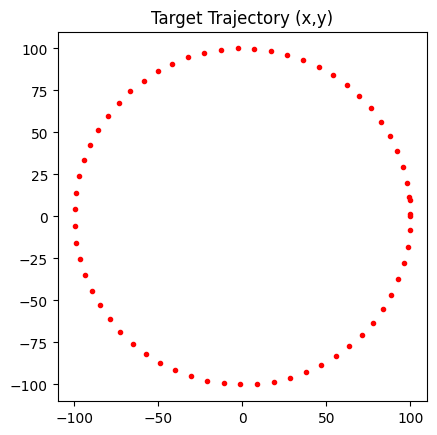

In [ ]:
NTRAJSTEPS = 65 # no gap for dt = 0.1
dt = 0.1

target = torch.zeros([NTRAJSTEPS,3], requires_grad=False, dtype=data, device=device)
targtrajarray = torch.arange(0.0, NTRAJSTEPS*dt, dt, dtype=data, device=device)

#Circle: compute positions
for i in range(len(targtrajarray)):
    target[i][0] = 100 * torch.cos(targtrajarray[i])  # Circle of radius 100
    target[i][1] = 100 * torch.sin(targtrajarray[i])

# Compute headings from positions
for i in range(1, len(targtrajarray)-1):  # no heading for first and last position
    prevpos = torch.tensor((target[i-1][0], target[i-1][1]), dtype=data, device=device)
    nextpos = torch.tensor((target[i+1][0], target[i+1][1]), dtype=data, device=device)
    heading = nextpos - prevpos
    target[i][2] = torch.atan2(heading[1], heading[0])

heading = torch.tensor((target[1][0], target[1][1]), dtype=data, device=device) - torch.tensor((target[0][0], target[0][1]), dtype=data, device=device)
target[0][2] = torch.atan2(heading[1], heading[0])

heading = torch.tensor((target[-1][0], target[-1][1]), dtype=data, device=device) - torch.tensor((target[-2][0], target[-2][1]), dtype=data, device=device)
target[-1][2] = torch.atan2(heading[1], heading[0])

# print(target.shape)
# print(target[:,2])

plt.figure()
plt.plot(target[:,0].cpu(), target[:,1].cpu(),'r.')
plt.axis('square');
plt.title('Target Trajectory (x,y)')

rad2deg = 180.0 / np.pi
deg2rad = np.pi / 180.0

###(Test Block No Need to Run) Test

In [ ]:
rad2deg = 180.0 / np.pi
deg2rad = np.pi / 180.0

#input variables
delta = torch.tensor(0.5729 * deg2rad, device=device)
s = torch.tensor(100.0, device=device)

theta = torch.tensor(90.0 * deg2rad, device=device)   # car heading in radians
x = torch.tensor(0.0, device=device)
y = torch.tensor(0.0, device=device)

L = torch.tensor(1.0, device=device) #constant
dt = torch.tensor(0.02, device=device) #constant

#Control parameters
Kp = torch.tensor(0.001, requires_grad=True, device=device)
Kd = torch.tensor(0.001, requires_grad=True, device=device)

lookahead = 0
control_cost_weight = torch.tensor(0.5, device=device)

In [ ]:
rad2deg = 180.0 / np.pi
deg2rad = np.pi / 180.0

#input variables
delta = torch.tensor(0.5729 * deg2rad, device=device)
s = torch.tensor(100.0, device=device)

theta = torch.tensor(90.0 * deg2rad, device=device)   # car heading in radians
x = torch.tensor(0.0, device=device)
y = torch.tensor(0.0, device=device)

L = torch.tensor(1.0, device=device) #constant
dt = torch.tensor(0.02, device=device) #constant

#Control parameters
Kp = torch.tensor(0.001, requires_grad=True, device=device)
Kd = torch.tensor(0.001, requires_grad=True, device=device)

lookahead = 0
control_cost_weight = torch.tensor(0.5, device=device)

for i in range(0, 5):
  compx = torch.cos(theta)
  compy = torch.sin(theta)
  distance = s*dt
  dx = compx*distance
  dy = compy*distance

  dtheta = (s/L) * torch.tan(delta) * dt
  xnew = x + dx
  ynew = y + dy
  thetanew = theta + dtheta
  thetanew = torch.fmod(thetanew,2.0*np.pi)

  inter_x = (target[:lookahead-1, 0] - xnew)**2
  inter_y = (target[:lookahead-1, 1] - ynew)**2
  dist = torch.sqrt(inter_x + inter_y)
  mi = torch.min(dist, dim=0)[1]

  distx = target[mi, 0] - xnew
  disty = target[mi, 1] - ynew
  nearest_trajectory = torch.stack((distx, disty), dim=0)

  car_xvec = torch.cos((torch.pi/2.0) + target[i,2])
  car_yvec = torch.sin((torch.pi/2.0) + target[i,2])
  carLeftvec = torch.stack((car_xvec, car_yvec), dim=0)

  error = -torch.dot(nearest_trajectory, carLeftvec)

  delta = -Kp * error + Kd * ((torch.tensor(10.0435)-error)/dt)
  delta = torch.max(delta,torch.tensor(-25.0*deg2rad)) # 10 deg max steering
  delta = torch.min(delta,torch.tensor(25.0*deg2rad)) # 10 deg max steering

  mse = torch.sqrt(torch.sum((torch.zeros(1) - error) ** 2))
  control_cost = (delta**2 + s**2).sum()
  total_loss = mse + control_cost_weight * control_cost

  total_loss.backward()
  Kp.data += 0.01 * Kp.grad
  Kd.data += 0.01 * Kd.grad
  print('Kd =', Kp.grad)
  print('Kd =', Kd.grad)

Kd = tensor(-0.7942)
Kd = tensor(161.7725)
Kd = tensor(-0.7942)
Kd = tensor(161.7725)
Kd = tensor(-0.7942)
Kd = tensor(161.7725)
Kd = tensor(-0.7942)
Kd = tensor(161.7725)
Kd = tensor(-0.7942)
Kd = tensor(161.7725)


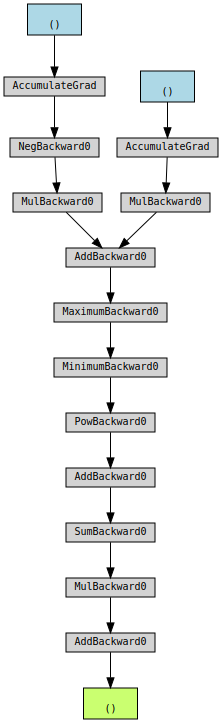

In [ ]:
make_dot(total_loss)

In [ ]:
'''input parameters'''
DRIVESTEPS = 400
NDRIVESTEPS = torch.tensor(DRIVESTEPS, device=device)
lookahead = torch.tensor(2, device=device)
maxsteerdeg = torch.tensor((25.0), device=device)

'''Constants'''
rad2deg = 180.0 / np.pi
deg2rad = np.pi / 180.0
dt = torch.tensor(0.02, device=device)
L = 1.0

''' control parameters '''
control_cost_weight = torch.tensor(0.5, dtype=torch.double, device=device)
#Test condition
# Kp = torch.rand(1, requires_grad=True,dtype=torch.double, device=device)
# Kd = torch.rand(1, requires_grad=True,dtype=torch.double, device=device)

# Circles outside track
# Kp = torch.tensor(0.0002, requires_grad=True, device=device)
# Kd = torch.tensor(0.0002, requires_grad=True, device=device)

# Decently follows circular track, slowly leaving it
# Kp = torch.tensor(0.001, requires_grad=True, device=device)
# Kd = torch.tensor(0.002, requires_grad=True, device=device)

#Perfect circle
Kp = torch.tensor(0.01, requires_grad=True, dtype=torch.double, device=device)
Kd = torch.tensor(0.001, requires_grad=True, dtype=torch.double, device=device)

print('Kp = ', Kp, 'Kd = ', Kd)
print('Gradients = ', Kp.grad, Kd.grad)

'''Output parameters'''
drivetrajtarray = torch.arange(0.0, NDRIVESTEPS*dt, dt, dtype=torch.double, device=device)
errorseries = torch.zeros(NDRIVESTEPS, dtype=torch.double, device=device)
deltaseries = torch.zeros(NDRIVESTEPS, dtype=torch.double, device=device)
speedseries = torch.zeros(NDRIVESTEPS, dtype=torch.double, device=device)
output = torch.zeros((NDRIVESTEPS,3), dtype=torch.double, device=device)
loss_series = torch.zeros(NDRIVESTEPS, dtype=torch.double, device=device)

'''Initialize all parameters'''
output[0,0] = 100.0
output[0,1] = 0.0
output[0,2] = 90.0* deg2rad
deltaseries[0] = 0.0
speedseries[0] = 150
minindex = 0
mindist = 0.0

'''Metric Visualizations'''
test_kp = torch.zeros(DRIVESTEPS)
test_kd = torch.zeros(DRIVESTEPS)
test_kp_grad = torch.zeros(DRIVESTEPS)
test_kd_grad = torch.zeros(DRIVESTEPS)

Kp =  tensor(0.0100, dtype=torch.float64, requires_grad=True) Kd =  tensor(0.0010, dtype=torch.float64, requires_grad=True)
Gradients =  None None


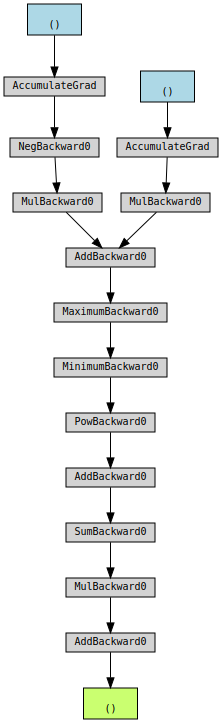

In [ ]:
make_dot(total_loss).render("3 drive step", format="png")
make_dot(total_loss)

###Funcitons

In [ ]:
def carkin(delta,s,theta,x,y,L,dt):
  '''
  Calculates forward car kinematics based on change of delta and speed wrt time step dt

  Input:
  delta = steering angle of a car
  s = speed of car
  theta = orientation of car
  x = x coordinate of car
  y = y coordinate of car
  L = length of car (constant)
  dt = time step for kinematics (constant)

  Output:
  xnew = updated x governed by kinematics (influenced by theta and speed)
  ynew = updated y governed by kinematics (influenced by theta and speed)
  thetanew = updated theta governed by kinematics (influenced by delta and speed)
  '''
  compx = torch.cos(theta)
  compy = torch.sin(theta)

  distance = s*dt
  dx = compx*distance
  dy = compy*distance

  dtheta = (s/L) * torch.tan(delta) * dt

  xnew = x + dx
  ynew = y + dy
  thetanew = theta + dtheta
  thetanew = torch.fmod(thetanew,2.0*np.pi) # Wrap theta at 2pi

  return xnew, ynew, thetanew


def findnearest(targetx, targety, carx, cary, lookahead):
  '''
  Input:
  targetx = target trajectory x coordinate
  targety = target trajectory y coordinate
  carx = current x
  cary = current y
  lookahead = trajectory ahead in path

  Output:
  minimum distance = minimum distance from the target trajectory
  minindex = specific trajectory in whole path
  '''
  inter_x = (target[:-lookahead-1, 0]- carx)**2
  inter_y = (target[:-lookahead-1, 1] - cary)**2
  dist = torch.sqrt(inter_x + inter_y)
  minindex = torch.argmin(dist)
  return minindex  # index of minimum distance


def deviation(mi, theta, carx, cary):
  '''

  Input:
  mi = minimum distance
  target = target trajectory
  carx = current x
  cary = current y

  Ouput:
  error
  '''
  distx = target[mi, 0] - carx
  disty = target[mi, 1] - cary
  nearest_trajectory = torch.stack((distx, disty), dim=0)

  car_xvec = torch.cos((torch.pi/2.0) + theta)
  car_yvec = torch.sin((torch.pi/2.0) + theta)
  carLeftvec = torch.stack((car_xvec, car_yvec), dim=0)

  error = -torch.dot(nearest_trajectory, carLeftvec)
  return error

def bound_pid(Kp, Kd):
  Kp = torch.max(Kp, torch.tensor(0.009,    dtype=data, device=device))
  Kp = torch.min(Kp, torch.tensor(0.001, dtype=data, device=device))
  Kd = torch.max(Kd, torch.tensor(0.004,   dtype=data, device=device))
  Kd = torch.min(Kd, torch.tensor(0.001,  dtype=data, device=device))
  return Kp, Kd

def pid( kp, kd, last, current):
  '''

  Input:
  Kp
  Kd
  current_error
  last_error

  Ouput:
  delta = updated delta
  '''
  # delta = -kp * error[iter] + kd * (( error[iter-1]-error[iter])/dt)
  delta = -kp * current + kd * ((last-current)/dt)
  delta = torch.max(delta,torch.tensor(-25.0*deg2rad, device=device)) # 10 deg max steering
  delta = torch.min(delta,torch.tensor(25.0*deg2rad,  device=device)) # 10 deg max steering
  return delta


def loss_fn(delta, speed, target, carxy, error):
  '''

  Input:
  delta
  speed
  control_cost_weight
  error

  Output:
  total_loss
  '''
  #MSE
  total_loss = torch.sqrt(torch.sum((torch.zeros(len(error), dtype=data, device=device) - error) ** 2))

  #MSE and Euclidean distance
  # total_loss = torch.sqrt(torch.sum((target[:,0:2].repeat(int(carxy.shape[0] / 65),1) - carxy[:,0:2]) ** 2))

  #Cosine similarity
  # cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  # total_loss = torch.sum((cos(target[:,0:2].repeat(int(carxy.shape[0] / 65),1), target[:,0:2].repeat(int(carxy.shape[0] / 65),1)) - cos(target[:,0:2].repeat(int(carxy.shape[0] / 65),1),  carxy[:,0:2]))**2)

  return total_loss

def forward(Kp, Kd,  drivestep, viz = 0):
  '''input parameters'''
  NDRIVESTEPS = torch.tensor(drivestep, device=device)
  lookahead = torch.tensor(2, device=device)
  maxsteerdeg = torch.tensor((25.0), device=device)

  '''Constants'''
  rad2deg = 180.0 / np.pi
  deg2rad = np.pi / 180.0
  dt = torch.tensor(0.02, dtype=data, device=device)
  L = 1.0

  ''' control parameters '''
  # Kp = torch.tensor(Kp, requires_grad=grad, device=device)
  # Kd = torch.tensor(Kd, requires_grad=grad, device=device)
  # Kp = torch.rand(1, requires_grad=True, device=device)
  # Kd = torch.rand(1, requires_grad=True, device=device)

  '''Output parameters'''
  drivetrajtarray = torch.arange(0.0, drivestep*dt, dt, dtype=data, device=device)
  errorseries = torch.zeros(drivestep, dtype=data, device=device)
  deltaseries = torch.zeros(drivestep, dtype=data, device=device)
  speedseries = torch.zeros(drivestep, dtype=data, device=device)
  output = torch.zeros((drivestep,3),  dtype=data, device=device)

  '''Initialize all parameters'''
  output[0,0] = 100.0
  output[0,1] = 0.0
  output[0,2] = 90.0* deg2rad
  deltaseries[0] = 0.0
  speedseries[0] = 150
  minindex = 0
  mindist = 0.0

  for i in range(1, drivestep):
    # print('Drivestep = ', i)
    # print('Kp = ', Kp.data, 'Kd = ', Kd.data)
    output[i,0], output[i,1], output[i,2] = carkin(deltaseries[i-1], speedseries[i-1], output[i-1,2].clone(), output[i-1,0].clone(), output[i-1,1].clone(), L, dt)
    # print('This is XY Theta = ', output[i,0].data, output[i,1].data, output[i,2].data)

    minindex = findnearest(target[:,0], target[:,1], output[i,0].clone(), output[i,1].clone(), lookahead)
    # print('This is min index =', minindex)

    errorseries[i] = deviation(minindex.detach().numpy(), output[i,2].clone(), output[i,0].clone(), output[i,1].clone())
    # print('This is error =', errorseries[i].data)

    # deltaseries[i] = pid(i, Kp, Kd, errorseries.clone())
    deltaseries[i] = pid(Kp, Kd, errorseries[i-1].clone(), errorseries[i].clone())
    # print('This is Delta = ', deltaseries[i].data)

    speedseries[i] = speedseries[i-1]
  total_loss = loss_fn(deltaseries, speedseries, target, output.clone(), errorseries.clone())

  if viz ==1 :
    plt.figure()
    plt.plot(target[:,0],target[:,1],'r.')
    plt.plot(output[0:-lookahead-1, 0].detach(), output[0:-lookahead-1, 1].detach())
    plt.axis('square');
    # plt.title('Target Trajectory (x,y) vs actual' + ' with ' + 'Fitness = '+ str(total_loss) );
    # plt.text(-50, 0, 'Kp='+str(Kp)+'Kd='+str(Kd))

    plt.figure()
    plt.plot(drivetrajtarray[:-1].detach(), errorseries[:].detach())
    plt.title('Cross-track error vs t')

  return total_loss

###(Test Block No Need to Run) Vizualization

tensor(19.6447)

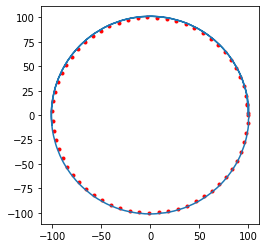

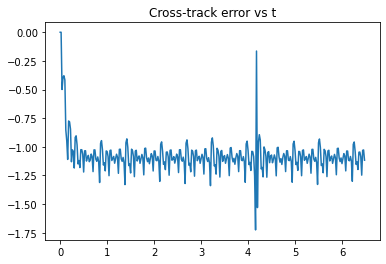

In [ ]:
forward(0.009, 0.006, 325, viz = 1)

In [ ]:
#Takes fair amount of time to generate whole hyperplane data
Kp_range = np.arange(0.001, 0.06, 0.001)
# print(Kp_range)
Kd_range = np.arange(0.001, 0.01, 0.0001)
# print(Kd_range)
Kp_viz, Kd_viz = np.meshgrid(Kp_range, Kd_range)
Kp_viz = torch.tensor(Kp_viz)
Kd_viz = torch.tensor(Kd_viz)
Kp_viz.shape, Kd_viz.shape

(torch.Size([90, 59]), torch.Size([90, 59]))

In [ ]:
#Takes fair amount of time to generate whole hyperplane data
J = torch.zeros(Kp_viz.shape)
print(J.shape)

for i in range(Kp_viz.shape[0]):
  for j in range(Kp_viz.shape[1]):
    J[i][j] = forward(Kp_viz[i][j], Kd_viz[i][j], 260)
    print(i, j, J[i][j])

Streaming output truncated to the last 5000 lines.
5 15 tensor(30.5890)
5 16 tensor(31.9415)
5 17 tensor(55.3580)
5 18 tensor(60.2410)
5 19 tensor(58.2060)
5 20 tensor(75.9140)
5 21 tensor(75.6709)
5 22 tensor(74.8495)
5 23 tensor(79.0358)
5 24 tensor(69.6673)
5 25 tensor(77.8834)
5 26 tensor(75.0166)
5 27 tensor(72.8074)
5 28 tensor(78.7967)
5 29 tensor(74.3258)
5 30 tensor(74.3697)
5 31 tensor(73.2907)
5 32 tensor(70.7989)
5 33 tensor(72.1628)
5 34 tensor(76.9599)
5 35 tensor(67.5962)
5 36 tensor(65.9841)
5 37 tensor(69.7757)
5 38 tensor(72.0810)
5 39 tensor(70.7445)
5 40 tensor(73.0450)
5 41 tensor(73.6229)
5 42 tensor(69.4830)
5 43 tensor(71.1617)
5 44 tensor(64.4664)
5 45 tensor(72.4159)
5 46 tensor(74.8201)
5 47 tensor(71.7301)
5 48 tensor(70.3416)
5 49 tensor(80.0533)
5 50 tensor(68.5218)
5 51 tensor(75.8834)
5 52 tensor(71.3860)
5 53 tensor(69.5367)
5 54 tensor(76.3858)
5 55 tensor(72.9716)
5 56 tensor(77.9555)
5 57 tensor(71.9944)
5 58 tensor(71.2951)
6 0 tensor(142.4180)
6 1 

In [ ]:
J , torch.amax(J) , torch.amin(J)

(tensor([[145.4838,  76.9448,  52.4073,  ...,  87.3800,  84.2497,  78.2252],
         [144.9271,  76.7358,  52.2646,  ...,  77.9676,  88.3334,  74.7861],
         [144.3973,  76.5401,  52.1455,  ...,  75.4546,  83.7339,  80.7283],
         ...,
         [100.8240,  68.0719,  44.1447,  ...,  62.8556,  62.0526,  61.6047],
         [105.5641,  65.2960,  47.2994,  ...,  62.8058,  61.9327,  61.5721],
         [105.2918,  65.0433,  45.9825,  ...,  63.0592,  62.2946,  61.6821]]),
 tensor(145.4838),
 tensor(5.3490))

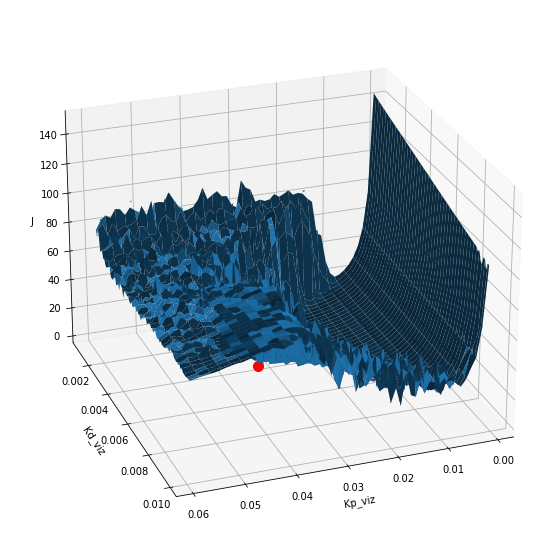

In [ ]:
#Takes fair amount of time to generate whole hyperplane data
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Kp_viz, Kd_viz, J)
ax.set_xlabel('Kp_viz')
ax.set_ylabel('Kd_viz')
ax.set_zlabel('J')

# find the minimum value and its location in the cost function
min_val = torch.min(J)
min_idx = torch.where(J == min_val)
min_kd = Kd_viz[min_idx][0]
min_kp = Kp_viz[min_idx][0]

# plot a red point at the location of the minimum value
ax.scatter(min_kp, min_kd, min_val, color='r', s=100)

# plot the contours of the cost function
ax.contour(Kp_viz, Kd_viz, J, levels=np.arange(torch.min(J), torch.max(J), 10))

# adjust the viewing angle to focus on the contour that corresponds to the minimum value
ax.view_init(elev=25, azim=70)
plt.show()

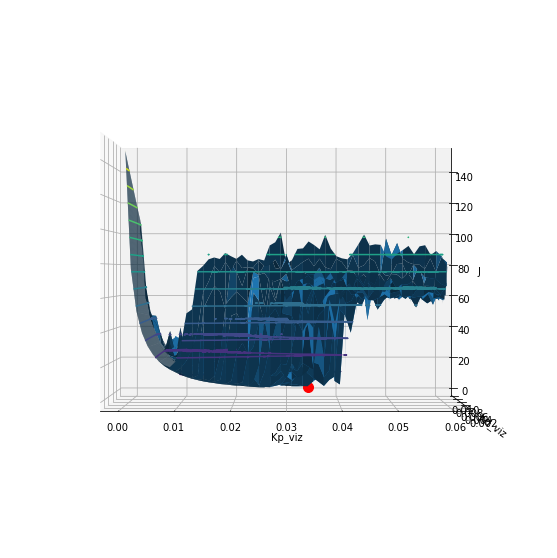

In [ ]:
ax.view_init(elev=0, azim=270)
fig

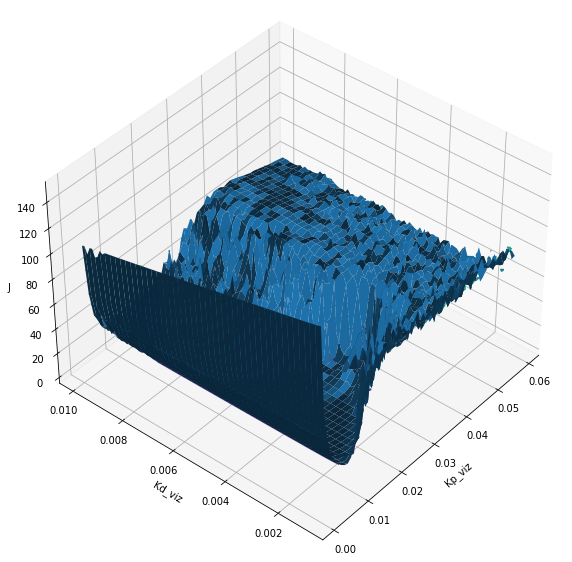

In [ ]:
ax.view_init(elev=40, azim=220)
fig

###Gradient Descent

initialization --> Kp =  0.9564587473869324 Kd =  0.04990319907665253 Loss = tensor(44.7733, grad_fn=<SqrtBackward0>)


Updated Kp =  0.03504042327404022 Updated Kd =  0.03504042327404022
Kp.grad =  tensor(-146175.1250) Kd.grad =  tensor(-5041.5571)
Epoch [10/500], Loss: 74.7328
Updated Kp =  0.0250093936920166 Updated Kd =  0.0250093936920166
Kp.grad =  tensor(-146175.1250) Kd.grad =  tensor(-5041.5571)
Epoch [20/500], Loss: 75.1496
Updated Kp =  0.020908048376441002 Updated Kd =  0.020908044651150703
Kp.grad =  tensor(-146175.1250) Kd.grad =  tensor(-5041.5571)
Epoch [30/500], Loss: 74.9227
Updated Kp =  0.01857863739132881 Updated Kd =  0.018578631803393364
Kp.grad =  tensor(-146175.1250) Kd.grad =  tensor(-5041.5571)
Epoch [40/500], Loss: 78.4945
Updated Kp =  0.01705198734998703 Updated Kd =  0.017051981762051582
Kp.grad =  tensor(-146175.1250) Kd.grad =  tensor(-5041.5571)
Epoch [50/500], Loss: 80.7279
Updated Kp =  0.015966828912496567 Updated Kd =  0.015966827049851418
Kp.grad =  tensor(-146175.1250) Kd.grad =  tensor(-5041.5571)
Epoch [60/500], Loss: 68.0070
Updated Kp =  0.015154056251049042 U

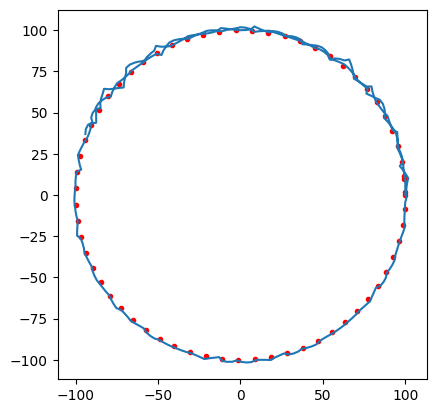

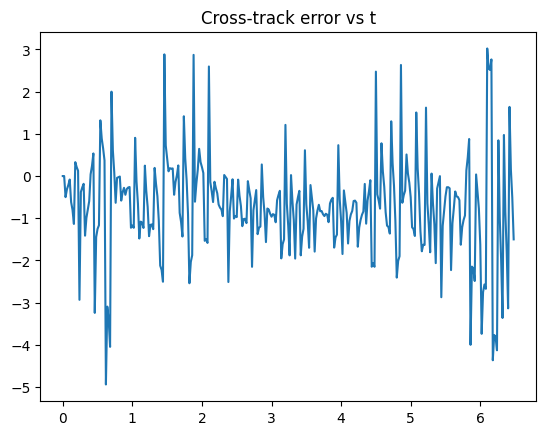

In [ ]:
epochs = 500
Loss = []
kp = []
kd = []
kp_grad = []
kd_grad = []
rand1 = np.random.uniform(0, 1.0)
rand2 = np.random.uniform(0, 0.1)
Kp = torch.tensor(rand1 , requires_grad=True, dtype=data, device=device)
Kd = torch.tensor(rand2 , requires_grad=True, dtype=data, device=device)
print('initialization -->', 'Kp = ', Kp.item(), 'Kd = ', Kd.item(), 'Loss =', forward(Kp, Kd,  325, viz = 0))

# optimizer = torch.optim.Adam([Kp, Kd], lr=0.001)
optimizer = torch.optim.RMSprop([Kp, Kd], lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0.0, momentum=0.001, centered=False, foreach=None, maximize=False, differentiable=False)

for epoch in range(1, epochs):
  Kp.data, Kd.data = bound_pid(Kp.data, Kd.data)
  loss = forward(Kp, Kd,  325, viz = 0)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epoch+1) % 10 == 0:
    print('Updated Kp = ', Kp.item(), 'Updated Kd = ', Kd.item())
    temp = forward(Kp.detach(), Kd.detach(), 325, viz = 0).item()
    Loss.append(temp)
    kp.append(Kp.detach().numpy())
    kd.append(Kd.detach().numpy())
    kp_grad.append(Kp.grad.detach().numpy())
    kd_grad.append(Kd.grad.detach().numpy())
    print('Kp.grad = ', Kp.grad, 'Kd.grad = ', Kd.grad)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {temp:.4f}")

print("Final parameters:")
print('Best performance = ', forward(Kp, Kd, 325, viz = 1), 'Kp = ', Kp.item(), 'Kd = ', Kd.item())

Text(0.5, 1.0, 'PD vs Epoch')

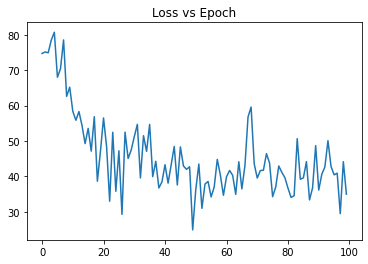

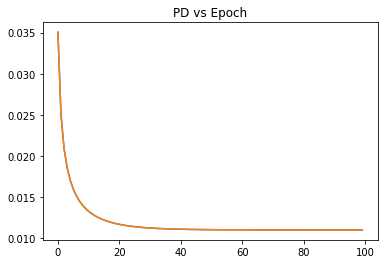

In [ ]:
plt.figure()
plt.plot(range(0, (epochs//10)), Loss)
plt.title('Loss vs Epoch')

plt.figure()
plt.plot(range(0, (epochs // 10)), kp)
plt.plot(range(0, (epochs // 10)), kd)
plt.title('PD vs Epoch')

# plt.figure()
# plt.plot(range(0, (epochs // 10)), kp_grad)
# plt.plot(range(0, (epochs // 10)),kd_grad)
# plt.title('PD_grad vs Epoch')

In [ ]:
Kp.item(), Kd.item()

(0.011010217480361462, 0.011010242626070976)

tensor(34.9446, grad_fn=<SqrtBackward0>)

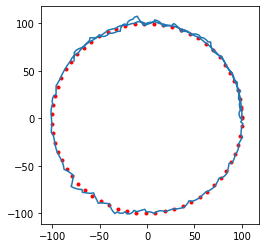

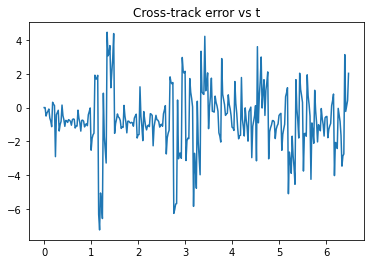

In [ ]:
forward(Kp, Kd, 325, viz = 1)